## Init

In [1]:
from transformers import AutoModel, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/xlm-roberta-large-en-ru")

/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:111: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [2]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
import json

# Open and load JSON file
with open(
    "/home/jupyter/datasphere/synthetic_dataset/samples_8.json",
    "r",
) as file:
    data = json.load(file)

In [4]:
import random

import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch import nn
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
unique_labels = [
    "address",
    "email",
    "fio",
    "ip",
    "ipv6",
    "login",
    "org",
    "password",
    "phone",
]

## Dataset

In [6]:
import random
from itertools import chain
from typing import Any, Dict, List, Tuple


def sample_and_split_diverse(
    data: Dict[Any, Dict[Any, Dict[Any, Dict[Any, List[Dict]]]]],
    n_samples: int,
    val_ratio: float,
    seed: int = None,
) -> Tuple[Tuple[List[str], List[Dict]], Tuple[List[str], List[Dict]]]:
    """
    Perform stratified sampling across (log_env, length) groups so that
    both train and val contain entries from each group.

    Args:
        data: nested dict of shape
              data[log_env][length][template][lang] -> list of {text, spans}
        n_samples: total number of examples (train + val)
        val_ratio: fraction of examples for validation
        seed: random seed for reproducibility

    Returns:
        ((train_texts, train_spans), (val_texts, val_spans))
    """
    if seed is not None:
        random.seed(seed)

    # 1. Flatten into groups
    groups: List[Tuple[Tuple[Any, Any], List[Dict]]] = []
    for log_env_val, lengths in data.items():
        for length_val, templates in lengths.items():
            entries = []
            for tmpl in templates.values():
                for lang_list in tmpl.values():
                    entries.extend(lang_list)
            if entries:
                groups.append(((log_env_val, length_val), entries))

    # Compute total available entries
    total_entries = sum(len(entries) for _, entries in groups)
    print("total_entries:", total_entries)
    if total_entries < n_samples:
        raise ValueError(f"Not enough total examples: {total_entries} < {n_samples}")

    n_val = int(n_samples * val_ratio)
    n_train = n_samples - n_val

    train_samples: List[Dict] = []
    val_samples: List[Dict] = []

    # 2. For each group, allocate proportional samples then split
    acc_train, acc_val = 0, 0
    for env_len, entries in tqdm(groups):
        group_size = len(entries)
        # number of samples to take from this group
        group_n = max(1, int(group_size / total_entries * n_samples))
        # adjust last group to exactly fill
        if acc_train + acc_val + group_n > n_samples:
            group_n = n_samples - (acc_train + acc_val)

        # number of val samples from this group
        group_val_n = int(group_n * val_ratio)
        group_train_n = group_n - group_val_n

        # sample without replacement
        sampled = random.sample(entries, group_n)
        val_subset = sampled[:group_val_n]
        train_subset = sampled[group_val_n:]

        val_samples.extend(val_subset)
        train_samples.extend(train_subset)
        acc_val += len(val_subset)
        acc_train += len(train_subset)

    # 3. If rounding left us short, fill remaining slots from the pools
    def fill(samples: List[Dict], pool: List[Dict], need: int):
        if need <= 0:
            return
        remaining = [e for e in pool if e not in samples]
        samples.extend(random.sample(remaining, need))

    fill(
        val_samples,
        list(chain.from_iterable(g for _, g in groups)),
        n_val - len(val_samples),
    )
    fill(
        train_samples,
        list(chain.from_iterable(g for _, g in groups)),
        n_train - len(train_samples),
    )

    # 4. Unpack texts and spans
    train_texts = [e["text"] for e in train_samples]
    train_spans = [e["spans"] for e in train_samples]
    val_texts = [e["text"] for e in val_samples]
    val_spans = [e["spans"] for e in val_samples]

    return ((train_texts, train_spans), (val_texts, val_spans))

In [7]:
import random
from itertools import chain
from typing import Any, Dict, List, Tuple
def sample_evenly_across_envs_and_lengths_safe(
    data: Dict[Any, Dict[Any, Dict[Any, Dict[Any, List[Dict]]]]],
    n_samples: int,
    val_ratio: float,
    seed: int = None
) -> Dict[Tuple[Any, Any], Tuple[Tuple[List[str], List[Dict]], Tuple[List[str], List[Dict]]]]:
    """
    Even sampling across all (log_env, length) groups, using as much as possible from small groups.
    """
    if seed is not None:
        random.seed(seed)

    # 1. Flatten groups
    groups: Dict[Tuple[Any, Any], List[Dict]] = {}
    for log_env_val, lengths in data.items():
        for length_val, templates in lengths.items():
            entries = []
            for tmpl in templates.values():
                for lang_list in tmpl.values():
                    entries.extend(lang_list)
            if entries:
                groups[(log_env_val, length_val)] = entries

    n_groups = len(groups)
    if n_groups == 0:
        raise ValueError("No non-empty (log_env, length) groups found.")

    per_group = n_samples // n_groups
    remainder = n_samples % n_groups

    result = {}
    total_used = 0
    available_slots = []

    # 2. First pass: take up to per_group (or less if not enough)
    for i, ((env, length), entries) in enumerate(groups.items()):
        extra = 1 if i < remainder else 0
        group_n = per_group + extra
        actual_n = min(len(entries), group_n)

        sampled = random.sample(entries, actual_n)
        n_val = int(actual_n * val_ratio)
        n_train = actual_n - n_val

        val_samples = sampled[:n_val]
        train_samples = sampled[n_val:]

        train_texts = [e['text'] for e in train_samples]
        train_spans = [e['spans'] for e in train_samples]
        val_texts = [e['text'] for e in val_samples]
        val_spans = [e['spans'] for e in val_samples]

        result[(env, length)] = ((train_texts, train_spans), (val_texts, val_spans))
        total_used += actual_n

        # Remember unused entries to possibly take more later
        remaining = [e for e in entries if e not in sampled]
        if remaining:
            available_slots.append(((env, length), remaining))

    # 3. Distribute leftover samples to any group with unused data
    leftover = n_samples - total_used
    i = 0
    while leftover > 0 and available_slots:
        env_length, pool = available_slots[i % len(available_slots)]
        to_add = min(leftover, len(pool))

        extra_samples = random.sample(pool, to_add)
        n_val = int(to_add * val_ratio)
        n_train = to_add - n_val
        val_samples = extra_samples[:n_val]
        train_samples = extra_samples[n_val:]

        train_texts, train_spans = result[env_length][0]
        val_texts, val_spans = result[env_length][1]

        train_texts.extend(e['text'] for e in train_samples)
        train_spans.extend(e['spans'] for e in train_samples)
        val_texts.extend(e['text'] for e in val_samples)
        val_spans.extend(e['spans'] for e in val_samples)

        result[env_length] = ((train_texts, train_spans), (val_texts, val_spans))

        leftover -= to_add
        i += 1

    print(f"Final total used: {sum(len(t[0]) + len(v[0]) for t, v in result.values())} examples")
    return result

def prepared_data(data_log, ner_data, env_ids, unique_labels):
    df = pd.DataFrame({
        "env_id": env_ids,
        "sentence": data_log,
        "ner": ner_data,
    })

    # Create label dictionary
    unique_labels_ner = ["O"] + sorted([f"B-{e}" for e in unique_labels] + [f"I-{e}" for e in unique_labels])
    label2id = {label: idx for idx, label in enumerate(unique_labels_ner)}
    id2label = {v: k for k, v in label2id.items()}

    # Tokenize text
    tokenized = df["sentence"].apply(lambda x: tokenizer.encode_plus(
        x,
        add_special_tokens=True,
        max_length=256,
        padding='max_length',
        truncation=True,
        return_offsets_mapping=True,
        return_attention_mask=True,
        return_tensors='pt'
    ))
    df["input_ids"] = tokenized.apply(lambda x: x["input_ids"].squeeze(0))
    df["attention_mask"] = tokenized.apply(lambda x: x["attention_mask"].squeeze(0))
    df["offset_mapping"] = tokenized.apply(lambda x: x["offset_mapping"].squeeze(0))

    return df, label2id, id2label, unique_labels_ner
def form_df(result):
    data_train, ner_train, env_ids_train = [], [], []
    data_val, ner_val, env_ids_val = [], [], []
    for (env, length), ((train_texts, train_spans), (val_texts, val_spans)) in result.items():
        env_key = (env, length)
        data_train.extend(train_texts)
        ner_train.extend(train_spans)
        env_ids_train.extend([env_key] * len(train_texts))

        data_val.extend(val_texts)
        ner_val.extend(val_spans)
        env_ids_val.extend([env_key] * len(val_texts))
    df, label2id, id2label, unique_labels_ner = prepared_data(data_train, ner_train, env_ids_train, unique_labels)
    df_val, _, _, _ = prepared_data(data_val, ner_val, env_ids_val, unique_labels)
  
    return df,df_val, label2id, id2label, unique_labels_ner

In [8]:
result = sample_evenly_across_envs_and_lengths_safe(data,100000, 0.05)

Final total used: 100000 examples


In [9]:
df,df_val, label2id, id2label, unique_labels_ner = form_df(result)

In [10]:
df.head()

,env_id,sentence,ner,input_ids,attention_mask,offset_mapping
0,"(apache_clf, short)",127.0.0.1 - stojan_2014 - [24/Jul/2025:20:54:4...,"[{'label': 'login', 'start': 13, 'end': 24, 'v...","[tensor(0), tensor(427), tensor(25691), tensor...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[[tensor(0), tensor(0)], [tensor(0), tensor(2)..."
1,"(apache_clf, short)",127.0.0.1 - abramovustin - [24/Jul/2025:20:54:...,"[{'label': 'login', 'start': 13, 'end': 25, 'v...","[tensor(0), tensor(427), tensor(25691), tensor...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[[tensor(0), tensor(0)], [tensor(0), tensor(2)..."
2,"(apache_clf, short)","1.2.3.4 - lonnie23 [2025-07-24] ""OPTIONS explo...","[{'label': 'login', 'start': 11, 'end': 19, 'v...","[tensor(0), tensor(23644), tensor(30073), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[[tensor(0), tensor(0)], [tensor(0), tensor(4)..."
3,"(apache_clf, short)",127.0.0.1 - bikovaninel - [24/Jul/2025:20:54:4...,"[{'label': 'login', 'start': 13, 'end': 24, 'v...","[tensor(0), tensor(427), tensor(25691), tensor...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[[tensor(0), tensor(0)], [tensor(0), tensor(2)..."
4,"(apache_clf, short)",127.0.0.1 - nifont2025 [24/Jul/2025:20:54:49 ]...,"[{'label': 'ipv6', 'start': 305, 'end': 343, '...","[tensor(0), tensor(427), tensor(25691), tensor...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[[tensor(0), tensor(0)], [tensor(0), tensor(2)..."


In [11]:
def mark_label(labels, idx, label2id, label_ner, start_ner=-1, start_token=1):
    if start_token < start_ner:
        labels[idx] = label2id[f"B-{label_ner}"]
    else:
        labels[idx] = label2id[f"I-{label_ner}"]
    return labels

In [12]:
def create_labels(ners, offsets, label2id):
    total_labels = []
    for ner, offset in tqdm(zip(ners, offsets)):
        labels = [label2id["O"]] * len(offset)
        idx = 0
        for item in offset:
            start_token = item[0]
            end_token = item[1]
            if start_token == 0 and end_token == 0:
                labels[idx] = -100
            else:
                for entity in ner:
                    start_ner = entity["start"]
                    end_ner = entity["end"]
                    label_ner = entity["label"]
                    if end_token >= start_ner and end_token < end_ner:
                        labels = mark_label(
                            labels, idx, label2id, label_ner, start_ner, start_token
                        )
                        break
                    elif end_ner > (start_token + 1) and start_token > start_ner:
                        labels = mark_label(labels, idx, label2id, label_ner)
                        break
            idx += 1
        total_labels.append(labels)
    return total_labels


df["labels"] = create_labels(df["ner"], df["offset_mapping"], label2id)
df_val["labels"] = create_labels(df_val["ner"], df_val["offset_mapping"], label2id)

95068it [13:02, 121.43it/s]
4932it [00:40, 122.31it/s]


In [13]:
# import os

# save_dir = "/home/jupyter/datasphere/project/model/"
# import os, json, sys
# import pandas as pd
# from tqdm import tqdm

# # ────────────────────────────────────────────────────────────────────────────────
# # 1. Генерация меток (оставляем ваш код)
# # ────────────────────────────────────────────────────────────────────────────────
# def create_labels(ners, offsets, label2id):
#     total_labels = []
#     for ner, offset in tqdm(zip(ners, offsets)):
#         labels = [label2id["O"]] * len(offset)
#         idx = 0
#         for start_token, end_token in offset:
#             if start_token == 0 and end_token == 0:
#                 labels[idx] = -100
#             else:
#                 for entity in ner:
#                     start_ner = entity["start"]
#                     end_ner   = entity["end"]
#                     label_ner = entity["label"]
#                     if end_token >= start_ner and end_token < end_ner:
#                         labels = mark_label(
#                             labels, idx, label2id, label_ner, start_ner, start_token
#                         )
#                         break
#                     elif end_ner > (start_token + 1) and start_token > start_ner:
#                         labels = mark_label(labels, idx, label2id, label_ner)
#                         break
#             idx += 1
#         total_labels.append(labels)
#     return total_labels

# df["labels"]     = create_labels(df["ner"],     df["offset_mapping"], label2id)
# df_val["labels"] = create_labels(df_val["ner"], df_val["offset_mapping"], label2id)

# # ────────────────────────────────────────────────────────────────────────────────
# # 2. Сохранение / загрузка без ujson
# # ────────────────────────────────────────────────────────────────────────────────
# def save_jsonl(df: pd.DataFrame, path: str) -> None:
#     """
#     Сохраняет DataFrame в JSONL, избегая ujson.
#     """
#     with open(path, "w", encoding="utf-8") as f:
#         for record in df.to_dict(orient="records"):
#             f.write(json.dumps(record, ensure_ascii=False))
#             f.write("\n")   # новая строка ─ новая запись

# def load_jsonl(path: str) -> pd.DataFrame:
#     """
#     Загружает JSONL обратно в DataFrame.
#     """
#     with open(path, "r", encoding="utf-8") as f:
#         rows = [json.loads(line) for line in f]
#     return pd.DataFrame(rows)

# # ── директория для сохранения
# save_dir = "data_json"
# os.makedirs(save_dir, exist_ok=True)

# train_path = os.path.join(save_dir, "train.jsonl")
# val_path   = os.path.join(save_dir, "validation.jsonl")

# # сохраняем
# save_jsonl(df,      train_path)
# save_jsonl(df_val,  val_path)

# print(f"✓ Train saved to {train_path}")
# print(f"✓ Val   saved to {val_path}")

# # ────────────────────────────────────────────────────────────────────────────────
# # 3. Проверяем загрузку
# # ────────────────────────────────────────────────────────────────────────────────
# df_loaded      = load_jsonl(train_path)
# df_val_loaded  = load_jsonl(val_path)

# assert df_loaded.equals(df) and df_val_loaded.equals(df_val)
# print("✅ Всё считается корректно – данные совпадают.")

9372it [01:41, 92.63it/s] 


KeyboardInterrupt: 

In [ ]:
# # ────────────────────────────────────────────────────────────────────────────────
# # 3. Загрузка (извлечение) обратно
# # ────────────────────────────────────────────────────────────────────────────────
# df_train_loaded = pd.read_json(train_path, orient="records", lines=True)
# df_val_loaded   = pd.read_json(val_path,   orient="records", lines=True)

# # Проверяем, что всё совпадает
# assert df_train_loaded.equals(df) and df_val_loaded.equals(df_val)
# print("✅ Датасеты успешно загружены, всё совпадает!")

In [13]:
grouped = df.groupby('env_id')
for env_key, group_df in grouped:
    print(f"Group: {env_key}, Count: {len(group_df)}")

Group: ('alb_access', 'long'), Count: 380
Group: ('alb_access', 'medium'), Count: 656
Group: ('alb_access', 'short'), Count: 656
Group: ('apache_clf', 'long'), Count: 1141
Group: ('apache_clf', 'medium'), Count: 1141
Group: ('apache_clf', 'short'), Count: 1521
Group: ('apache_combined', 'long'), Count: 656
Group: ('apache_combined', 'medium'), Count: 710
Group: ('apache_combined', 'short'), Count: 1521
Group: ('apache_error', 'long'), Count: 656
Group: ('apache_error', 'medium'), Count: 656
Group: ('apache_error', 'short'), Count: 656
Group: ('application_trace', 'long'), Count: 655
Group: ('application_trace', 'medium'), Count: 655
Group: ('application_trace', 'short'), Count: 655
Group: ('bank_transaction', 'long'), Count: 655
Group: ('bank_transaction', 'medium'), Count: 655
Group: ('bank_transaction', 'short'), Count: 655
Group: ('chat_message', 'long'), Count: 655
Group: ('chat_message', 'medium'), Count: 655
Group: ('chat_message', 'short'), Count: 655
Group: ('cisco_asa', 'long'

In [14]:
df["sentence"][0]

'127.0.0.1 - stojan_2014 - [24/Jul/2025:20:54:49 ] "POST explore/posts HTTP/1.1" 301 118226 "http://www.sibirski.info/wp-contentcategory.html" "Mozilla/5.0 (Windows 95; raj-IN; rv:1.9.0.20) Gecko/6507-06-16 18:38:31 Firefox/3.8" д. Сосновый Бор, пр. Карьерный, д. 53 к. 6/1, 593214 ip.info a@1nJ53aay'

In [15]:
df

,env_id,sentence,ner,input_ids,attention_mask,offset_mapping,labels
0,"(apache_clf, short)",127.0.0.1 - stojan_2014 - [24/Jul/2025:20:54:4...,"[{'label': 'login', 'start': 13, 'end': 24, 'v...","[tensor(0), tensor(427), tensor(25691), tensor...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[[tensor(0), tensor(0)], [tensor(0), tensor(2)...","[-100, 0, 0, 0, 0, 0, 6, 15, 15, 15, 0, 0, 0, ..."
1,"(apache_clf, short)",127.0.0.1 - abramovustin - [24/Jul/2025:20:54:...,"[{'label': 'login', 'start': 13, 'end': 25, 'v...","[tensor(0), tensor(427), tensor(25691), tensor...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[[tensor(0), tensor(0)], [tensor(0), tensor(2)...","[-100, 0, 0, 0, 0, 0, 6, 15, 15, 15, 15, 0, 0,..."
2,"(apache_clf, short)","1.2.3.4 - lonnie23 [2025-07-24] ""OPTIONS explo...","[{'label': 'login', 'start': 11, 'end': 19, 'v...","[tensor(0), tensor(23644), tensor(30073), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[[tensor(0), tensor(0)], [tensor(0), tensor(4)...","[-100, 0, 0, 0, 0, 6, 15, 15, 0, 0, 0, 0, 0, 0..."
3,"(apache_clf, short)",127.0.0.1 - bikovaninel - [24/Jul/2025:20:54:4...,"[{'label': 'login', 'start': 13, 'end': 24, 'v...","[tensor(0), tensor(427), tensor(25691), tensor...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[[tensor(0), tensor(0)], [tensor(0), tensor(2)...","[-100, 0, 0, 0, 0, 0, 6, 15, 15, 15, 0, 0, 0, ..."
4,"(apache_clf, short)",127.0.0.1 - nifont2025 [24/Jul/2025:20:54:49 ]...,"[{'label': 'ipv6', 'start': 305, 'end': 343, '...","[tensor(0), tensor(427), tensor(25691), tensor...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[[tensor(0), tensor(0)], [tensor(0), tensor(2)...","[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...
95063,"(password_reset, long)",A password reset was requested for nikiforovva...,"[{'label': 'email', 'start': 36, 'end': 62, 'v...","[tensor(0), tensor(62), tensor(18713), tensor(...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[[tensor(0), tensor(0)], [tensor(0), tensor(1)...","[-100, 0, 0, 0, 0, 0, 0, 0, 2, 11, 11, 11, 11,..."
95064,"(password_reset, long)",A password reset was requested for januari_54@...,"[{'label': 'email', 'start': 36, 'end': 56, 'v...","[tensor(0), tensor(62), tensor(18713), tensor(...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[[tensor(0), tensor(0)], [tensor(0), tensor(1)...","[-100, 0, 0, 0, 0, 0, 0, 0, 2, 11, 11, 11, 11,..."
95065,"(password_reset, long)",A password reset request was initiated for use...,"[{'label': 'login', 'start': 49, 'end': 62, 'v...","[tensor(0), tensor(62), tensor(18713), tensor(...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[[tensor(0), tensor(0)], [tensor(0), tensor(1)...","[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 15, 15, 1..."
95066,"(password_reset, long)",A password reset request was initiated for use...,"[{'label': 'login', 'start': 49, 'end': 60, 'v...","[tensor(0), tensor(62), tensor(18713), tensor(...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[[tensor(0), tensor(0)], [tensor(0), tensor(1)...","[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 15, 15, 1..."


In [16]:
df["ner"][0]

[{'label': 'login', 'start': 13, 'end': 24, 'value': 'stojan_2014'},
 {'label': 'address',
  'start': 229,
  'end': 281,
  'value': 'д. Сосновый Бор, пр. Карьерный, д. 53 к. 6/1, 593214'},
 {'label': 'password', 'start': 290, 'end': 300, 'value': 'a@1nJ53aay'}]

In [17]:
def test_tokens(labels, input_ids, offset):
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    token_labels = [id2label[l] if l != -100 else "IGNORED" for l in labels]
    for t, l, o in zip(tokens, token_labels, offset):
        print(f"{t:15} → {l}, {o}")


test_tokens(df["labels"][0], df["input_ids"][0], df["offset_mapping"][0])

<s>             → IGNORED, tensor([0, 0])
▁12             → O, tensor([0, 2])
7.0             → O, tensor([2, 5])
.               → O, tensor([5, 6])
0.1             → O, tensor([6, 9])
▁-              → O, tensor([ 9, 11])
▁sto            → B-login, tensor([11, 15])
jan             → I-login, tensor([15, 18])
_               → I-login, tensor([18, 19])
2014            → I-login, tensor([19, 23])
▁-              → O, tensor([23, 25])
▁[              → O, tensor([25, 27])
24              → O, tensor([27, 29])
/               → O, tensor([29, 30])
Jul             → O, tensor([30, 33])
/20             → O, tensor([33, 36])
25              → O, tensor([36, 38])
:20             → O, tensor([38, 41])
:               → O, tensor([41, 42])
54              → O, tensor([42, 44])
:               → O, tensor([44, 45])
49              → O, tensor([45, 47])
▁               → O, tensor([47, 48])
]               → O, tensor([48, 49])
▁"              → O, tensor([49, 51])
P               → O, tensor([5

In [18]:
df["env_id"] = np.random.randint(0, 100, size=(len(df)))
df.head()

,env_id,sentence,ner,input_ids,attention_mask,offset_mapping,labels
0,60,127.0.0.1 - stojan_2014 - [24/Jul/2025:20:54:4...,"[{'label': 'login', 'start': 13, 'end': 24, 'v...","[tensor(0), tensor(427), tensor(25691), tensor...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[[tensor(0), tensor(0)], [tensor(0), tensor(2)...","[-100, 0, 0, 0, 0, 0, 6, 15, 15, 15, 0, 0, 0, ..."
1,22,127.0.0.1 - abramovustin - [24/Jul/2025:20:54:...,"[{'label': 'login', 'start': 13, 'end': 25, 'v...","[tensor(0), tensor(427), tensor(25691), tensor...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[[tensor(0), tensor(0)], [tensor(0), tensor(2)...","[-100, 0, 0, 0, 0, 0, 6, 15, 15, 15, 15, 0, 0,..."
2,96,"1.2.3.4 - lonnie23 [2025-07-24] ""OPTIONS explo...","[{'label': 'login', 'start': 11, 'end': 19, 'v...","[tensor(0), tensor(23644), tensor(30073), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[[tensor(0), tensor(0)], [tensor(0), tensor(4)...","[-100, 0, 0, 0, 0, 6, 15, 15, 0, 0, 0, 0, 0, 0..."
3,74,127.0.0.1 - bikovaninel - [24/Jul/2025:20:54:4...,"[{'label': 'login', 'start': 13, 'end': 24, 'v...","[tensor(0), tensor(427), tensor(25691), tensor...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[[tensor(0), tensor(0)], [tensor(0), tensor(2)...","[-100, 0, 0, 0, 0, 0, 6, 15, 15, 15, 0, 0, 0, ..."
4,70,127.0.0.1 - nifont2025 [24/Jul/2025:20:54:49 ]...,"[{'label': 'ipv6', 'start': 305, 'end': 343, '...","[tensor(0), tensor(427), tensor(25691), tensor...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[[tensor(0), tensor(0)], [tensor(0), tensor(2)...","[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [19]:
from torch.utils.data import Dataset


class EnvBalancedNERDataset(Dataset):
    def __init__(self, df):
        self.original_env_groups = {}
        for env_id in sorted(df['env_id'].unique(), key=str):
            group = df[df['env_id'] == env_id]
            examples = group.to_dict(orient="records")
            self.original_env_groups[env_id] = examples

        self.reset_epoch()

    def reset_epoch(self, seed: int = None):
        self.env_groups = {}
        for env_id, examples in self.original_env_groups.items():
            shuffled = examples.copy()
            if seed is not None:
                random.Random(seed + hash(env_id)).shuffle(shuffled)
            else:
                random.shuffle(shuffled)
            self.env_groups[env_id] = shuffled

    def __len__(self):
        return sum(len(g) for g in self.env_groups.values())

    def get_next_balanced_batch(self):
        batch = []
        for env_id in list(self.env_groups.keys()):
            group = self.env_groups[env_id]
            if group:
                example = group.pop(0)
                item = {
                    "input_ids": torch.tensor(example["input_ids"]),
                    "attention_mask": torch.tensor(example["attention_mask"]),
                    "labels": torch.tensor(example["labels"])
                }
                batch.append(item)
            if not self.env_groups[env_id]:
                del self.env_groups[env_id]

        return self.collate_fn(batch) if batch else None

    def __iter__(self):
        # return generator that yields batches until exhausted
        while True:
            batch = self.get_next_balanced_batch()
            if batch is None:
                break
            yield batch

    def collate_fn(self, batch):
        return {
            "input_ids": torch.stack([torch.tensor(item["input_ids"]) for item in batch]),
            "attention_mask": torch.stack([torch.tensor(item["attention_mask"]) for item in batch]),
            "labels": torch.stack([torch.tensor(item["labels"]) for item in batch])
        }

## Models

### Baseline

In [20]:
class TokenClassifierHead(nn.Module):
    def __init__(self, hidden_size, num_labels):
        """
        Classification head for token-level predictions.
        """
        super(TokenClassifierHead, self).__init__()
        self.classifier = nn.Linear(hidden_size, num_labels)

    def forward(self, x):
        """
        Args:
            x: tensor of shape [batch_size, seq_len, hidden_size]
        Returns:
            logits: tensor of shape [batch_size, seq_len, num_labels]
        """
        logits = self.classifier(x)
        return logits

In [21]:
class BERTForNER(nn.Module):
    def __init__(self, model, num_labels):
        """
        BERT + token classification head for NER.
        """
        super(BERTForNER, self).__init__()
        self.bert = model
        hidden_size = self.bert.config.hidden_size
        self.dropout = nn.Dropout(0.1)
        self.classifier = TokenClassifierHead(hidden_size, num_labels)

    def forward(self, input_ids, attention_mask=None):
        """
        Args:
            input_ids: [batch_size, seq_len]
            attention_mask: [batch_size, seq_len]
            token_type_ids: [batch_size, seq_len]
        Returns:
            logits: [batch_size, seq_len, num_labels]
        """
        outputs = self.bert(
            input_ids=input_ids, attention_mask=attention_mask, return_dict=True
        )
        # Get all token embeddings
        sequence_output = (
            outputs.last_hidden_state
        )  # [batch_size, seq_len, hidden_size]
        sequence_output = self.dropout(sequence_output)

        # Predict logits for each token
        logits = self.classifier(sequence_output)  # [batch_size, seq_len, num_labels]
        return logits

### BIRM

In [22]:
class EBD(nn.Module):
    def __init__(self, d_env):
        super(EBD, self).__init__()
        self.embedings = torch.nn.Embedding(d_env, 1).to(device)
        self.re_init()

    def re_init(self):
        self.embedings.weight.data.fill_(1.0)

    def re_init_with_noise(self, d_env):
        rd = torch.normal(torch.Tensor([1] * d_env), torch.Tensor([0.1] * d_env))
        self.embedings.weight.data = rd.view(-1, 1).to(device)

    def forward(self, e):
        return self.embedings(e.long())

## Train

In [23]:
# ================================================================
# PLOT utils
# ================================================================
from IPython.display import clear_output
import matplotlib.pyplot as plt, math
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def plot_batch_metrics(history, metrics):
    clear_output(wait=True)
    plt.close('all')

    cols, rows = 4, math.ceil(len(metrics)/4)
    fig, axes  = plt.subplots(rows, cols, figsize=(4*cols, 3*rows))
    axes = axes.flatten()

    for i, m in enumerate(metrics):
        ax = axes[i]
        ax.plot(history['batch_steps'], history['train'][m], label='Train', color='tab:blue')
        if history['val_steps']:                       # есть ли валидационные точки
            ax.plot(history['val_steps'], history['val'][m], label='Val',
                    color='tab:orange', marker='o', ls='--')
        ax.set_title(m); ax.set_xlabel('global step'); ax.set_ylabel(m); ax.legend()

    for j in range(len(metrics), len(axes)):
        axes[j].axis('off')
    plt.tight_layout(); plt.show()


# ----------------------------------------------------------------
# helpers
# ----------------------------------------------------------------
def accumulate_metrics(preds, labs):
    """macro / micro + accuracy"""
    p_ma, r_ma, f1_ma, _ = precision_recall_fscore_support(labs, preds,
                                                           average='macro', zero_division=0)
    p_mi, r_mi, f1_mi, _ = precision_recall_fscore_support(labs, preds,
                                                           average='micro', zero_division=0)
    acc = accuracy_score(labs, preds)
    return p_ma, p_mi, r_ma, r_mi, f1_ma, f1_mi, acc


def init_history(metric_names):
    return {
        'batch_steps': [],
        'val_steps'  : [],
        'train'      : {m: [] for m in metric_names},
        'val'        : {m: [] for m in metric_names},
        'train_epoch': {m: [] for m in metric_names},
    }

In [24]:
import torch
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from tqdm.auto import tqdm

def train(model, df, df_val, unique_labels_ner,
          train_loader, val_loader,
          batch_size=8, epochs=2,
          plot_every_k=15,              # как часто обновлять картинку
          val_every_k =15):            # как часто вычислять val
    # ------------- подготовка ----------------------------------------------
    num_labels = len(unique_labels_ner)
    d_env      = 145    # len(df["env_id"].unique())
    device     = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # «замораживаем» первые слои
    for _, param in model.bert.encoder.layer[:1].named_parameters():
        param.requires_grad = False

    lamda = 10
    annealing_batches = 50
    ft_batches = 200
    n_samples = 1
    ebd = EBD(d_env)           # как и раньше

    optimizer = AdamW(model.parameters(), lr=1e-5)

    class_weights       = torch.ones(num_labels, device=device) * 5
    class_weights[0]    = 0.2
    criterion           = CrossEntropyLoss(weight=class_weights, ignore_index=-100)

    # ---------------- метрики / история -------------------------------------
    metric_names = ['loss','precision_macro','precision_micro',
                    'recall_macro','recall_micro','f1_macro','f1_micro','accuracy']
    history      = init_history(metric_names)

    global_step  = 0
    # ---------------- основной цикл -----------------------------------------
    for epoch in range(1, epochs+1):
        model.train()
        train_loader.reset_epoch(seed=42)
        val_loader.reset_epoch(seed=42)

        epoch_preds, epoch_labels, epoch_losses = [], [], []

        # ----------------------------------------------------------------- #
        for b_n, batch in tqdm(enumerate(train_loader),
                               total=len(train_loader),
                               desc=f'Epoch {epoch}/{epochs} — train'):
            # ---------- forward + penalty «как было» ----------------------
            if b_n >= 600:
                return history
            loss, penalty = 0., 0.
            batch_preds, batch_labels = [], []

            for sample in range(n_samples):
                ebd.re_init_with_noise(d_env)
                losses_e = []
                for i_env in range(len(batch['input_ids'])):
                    input_ids      = batch['input_ids'][i_env].unsqueeze(0).to(device)
                    attention_mask = batch['attention_mask'][i_env].unsqueeze(0).to(device)
                    labels         = batch['labels'][i_env].unsqueeze(0).to(device)

                    logits         = model(input_ids, attention_mask)
                    G_train_e      = torch.ones_like(logits) * i_env
                    logits_w       = logits * G_train_e
                    loss_e         = criterion(logits_w.view(-1, num_labels), labels.view(-1))
                    losses_e.append(loss_e)

                    # собираем предсказания / лейблы для метрик на батче -----
                    preds_e = torch.argmax(logits, -1).view(-1).cpu().numpy()
                    labs_e  = labels.view(-1).cpu().numpy()
                    mask    = labs_e != -100
                    batch_preds .extend(preds_e[mask])
                    batch_labels.extend(labs_e [mask])

                loss_t   = torch.stack(losses_e)
                loss += loss_t.mean() * (len(losses_e) / 145 / n_samples)
                penalty +=  ((loss_t - loss_t.mean())**2).mean() * (len(losses_e) / 145 / n_samples)


            # ---------- оптимизация ---------------------------------------
            optimizer.zero_grad()
            penalty_coef = 0
            if b_n <= annealing_batches:
                penalty_coef = lamda * (b_n / annealing_batches)
            if b_n > annealing_batches:
                penalty_coef = lamda
            if b_n > ft_batches:
                penalty_coef = penalty_coef * 0.99 ** (b_n - ft_batches)
            loss_total = loss + penalty * penalty_coef
            loss_total.backward()
            optimizer.step()

            # ---------- метрики Train (батч) -------------------------------
            p_ma, p_mi, r_ma, r_mi, f1_ma, f1_mi, acc = accumulate_metrics(batch_preds, batch_labels)

            history['batch_steps'].append(global_step)
            history['train']['loss']            .append(loss_total.item())
            history['train']['precision_macro'] .append(p_ma)
            history['train']['precision_micro'] .append(p_mi)
            history['train']['recall_macro']    .append(r_ma)
            history['train']['recall_micro']    .append(r_mi)
            history['train']['f1_macro']        .append(f1_ma)
            history['train']['f1_micro']        .append(f1_mi)
            history['train']['accuracy']        .append(acc)

            epoch_preds .extend(batch_preds)
            epoch_labels.extend(batch_labels)
            epoch_losses.append(loss_total.item())

            # ---------- валидация ONLINE -----------------------------------
            if global_step % val_every_k == 0 and global_step != 0:
                model.eval()
                val_preds, val_labels, val_losses = [], [], []

                val_loader.reset_epoch(seed=42)
                cnt = 0
                with torch.no_grad():
                    for v_batch in val_loader:
                        cnt += 1
                        v_ids  = v_batch['input_ids'].to(device)
                        v_mask = v_batch['attention_mask'].to(device)
                        v_y    = v_batch['labels'].to(device)

                        v_logits  = model(v_ids, v_mask)
                        v_loss    = criterion(v_logits.view(-1, num_labels),
                                              v_y.view(-1))
                        val_losses.append(v_loss.item())

                        vp = torch.argmax(v_logits, -1).view(-1).cpu().numpy()
                        vl = v_y.view(-1).cpu().numpy()
                        m  = vl != -100
                        val_preds .extend(vp[m]); val_labels.extend(vl[m])

                pv_ma, pv_mi, rv_ma, rv_mi, fv_ma, fv_mi, vacc = accumulate_metrics(val_preds, val_labels)
                history['val_steps'].append(global_step)
                history['val']['loss']            .append(sum(val_losses)/cnt)
                history['val']['precision_macro'] .append(pv_ma)
                history['val']['precision_micro'] .append(pv_mi)
                history['val']['recall_macro']    .append(rv_ma)
                history['val']['recall_micro']    .append(rv_mi)
                history['val']['f1_macro']        .append(fv_ma)
                history['val']['f1_micro']        .append(fv_mi)
                history['val']['accuracy']        .append(vacc)

                model.train()  # не забываем вернуть режим обучения

            # ---------- отрисовка графиков ----------------------------------
            if global_step % plot_every_k == 0:
                plot_batch_metrics(history, metric_names)

            global_step += 1
        # ------------------ конец эпохи: сводка ------------------------------
        ep_loss = sum(epoch_losses)/len(epoch_losses)
        p_ma, p_mi, r_ma, r_mi, f1_ma, f1_mi, acc_ep = accumulate_metrics(epoch_preds, epoch_labels)

        history['train_epoch']['loss']            .append(ep_loss)
        history['train_epoch']['precision_macro'] .append(p_ma)
        history['train_epoch']['precision_micro'] .append(p_mi)
        history['train_epoch']['recall_macro']    .append(r_ma)
        history['train_epoch']['recall_micro']    .append(r_mi)
        history['train_epoch']['f1_macro']        .append(f1_ma)
        history['train_epoch']['f1_micro']        .append(f1_mi)
        history['train_epoch']['accuracy']        .append(acc_ep)

        print(f'\nEpoch {epoch} summary — loss: {ep_loss:.4f} | '
              f'f1_macro: {f1_ma:.4f} | acc: {acc_ep:.4f}\n')
    # ------------------------------------------------------------------------
    return history

In [ ]:
# import torch, gc
# gc.collect()
# torch.cuda.empty_cache()
# del model
# del optimizer

In [27]:
base_model = AutoModel.from_pretrained("DeepPavlov/xlm-roberta-large-en-ru")
model = BERTForNER(base_model, len(unique_labels_ner)).to(device)

In [28]:
train_loader = EnvBalancedNERDataset(df)
val_loader = EnvBalancedNERDataset(df_val)

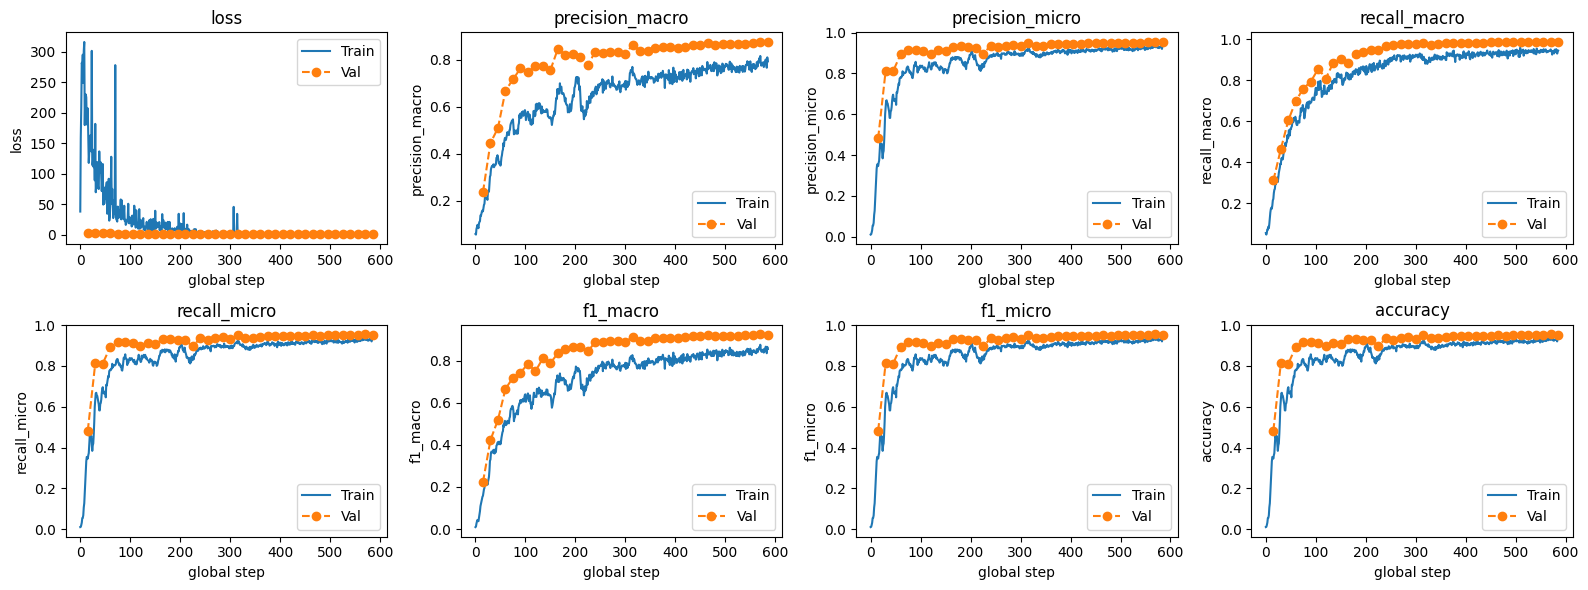

Epoch 1/2 — train:   1%|          | 600/95068 [1:23:44<219:44:06,  8.37s/it]


{'batch_steps': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  1

In [29]:
torch.cuda.empty_cache()
train(model, df, df_val, unique_labels_ner, train_loader, val_loader, batch_size=8, epochs=2)

In [30]:
torch.save(model, "/home/jupyter/datasphere/project/model/bertner_with_scheduler.pth")

## Results

In [29]:
def predict(text, model, tokenizer, id2label, device="cpu"):
    """
    Run NER prediction on raw text.

    Args:
        text (str): Raw input text.
        model (nn.Module): Your trained BERTForNER model.
        tokenizer: Hugging Face tokenizer.
        id2label (dict): Mapping from label IDs to label names.
        device (str): "cpu" or "cuda".
    Returns:
        List of (token, predicted_label)
    """
    # Tokenize input text
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,  # Adds [CLS] and [SEP]
        max_length=256,  # Pad/truncate to max length
        padding="max_length",
        truncation=True,
        return_offsets_mapping=True,
        return_attention_mask=True,
        return_tensors="pt",  # Return PyTorch tensors
    )
    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)

    # Set model to eval mode
    model.eval()
    with torch.no_grad():
        # Forward pass
        logits = model(input_ids, attention_mask)
        predictions = torch.argmax(logits, dim=-1)  # [batch_size, seq_len]

    # Convert IDs to tokens and labels
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    print(predictions)
    predicted_labels = [id2label[p.item()] for p in predictions[0]]

    # Filter out special tokens ([CLS], [SEP], [PAD])
    filtered_results = []
    for token, label in zip(tokens, predicted_labels):
        if token not in tokenizer.all_special_tokens:
            filtered_results.append((token, label))

    return filtered_results

In [61]:
inspect_id = 100

In [62]:
df_val["sentence"][inspect_id]

'f5_bigip: 22/Jul/2025:15:56:21  116.72.112.173:26329 -> 106.15.118.167:42215 User: Руслан Афанасьевич Федоров (timofeknjazev@mail.ru) accessed http://www.oao.edu/ on behalf of Алтайвагон at п. Воркута, наб. Л.Толстого, д. 33, 238532'

In [63]:
df_val["ner"][inspect_id]

[{'label': 'fio',
  'start': 84,
  'end': 110,
  'value': 'Руслан Афанасьевич Федоров'},
 {'label': 'email',
  'start': 112,
  'end': 133,
  'value': 'timofeknjazev@mail.ru'},
 {'label': 'org', 'start': 177, 'end': 187, 'value': 'Алтайвагон'},
 {'label': 'address',
  'start': 191,
  'end': 233,
  'value': 'п. Воркута, наб. Л.Толстого, д. 33, 238532'}]

In [64]:
filtered_results = predict(
    df_val["sentence"][inspect_id], model, tokenizer, id2label, device="cuda"
)

tensor([[10,  6, 15,  0, 15, 15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  4, 13,
         13, 13, 13, 13, 13,  0, 13, 13, 13,  0,  4, 13, 13, 13, 13, 13, 13,  0,
         13, 13,  0,  0,  0,  3, 12, 12, 12, 12, 12, 12,  0,  2, 11, 11, 11, 11,
         11, 11, 11, 10, 11,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0, 10, 16, 16, 16,  0,  1, 10, 10, 10, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 13, 13, 13, 13, 13, 13,
         13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
         13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
         13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
         13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
         13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
         13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
         13, 13, 13, 13, 13,

In [65]:
filtered_results

[('▁f', 'B-login'),
 ('5', 'I-login'),
 ('_', 'O'),
 ('big', 'I-login'),
 ('ip', 'I-login'),
 (':', 'O'),
 ('▁22', 'O'),
 ('/', 'O'),
 ('Jul', 'O'),
 ('/20', 'O'),
 ('25', 'O'),
 (':15', 'O'),
 (':', 'O'),
 ('56', 'O'),
 (':21', 'O'),
 ('▁116', 'B-ip'),
 ('.', 'I-ip'),
 ('72', 'I-ip'),
 ('.', 'I-ip'),
 ('11', 'I-ip'),
 ('2.1', 'I-ip'),
 ('73', 'I-ip'),
 (':', 'O'),
 ('26', 'I-ip'),
 ('3', 'I-ip'),
 ('29', 'I-ip'),
 ('▁->', 'O'),
 ('▁106', 'B-ip'),
 ('.', 'I-ip'),
 ('15', 'I-ip'),
 ('.', 'I-ip'),
 ('11', 'I-ip'),
 ('8.1', 'I-ip'),
 ('67', 'I-ip'),
 (':', 'O'),
 ('4', 'I-ip'),
 ('22', 'I-ip'),
 ('15', 'O'),
 ('▁User', 'O'),
 (':', 'O'),
 ('▁Руслан', 'B-fio'),
 ('▁А', 'I-fio'),
 ('фан', 'I-fio'),
 ('ась', 'I-fio'),
 ('евич', 'I-fio'),
 ('▁Федор', 'I-fio'),
 ('ов', 'I-fio'),
 ('▁(', 'O'),
 ('tim', 'B-email'),
 ('of', 'I-email'),
 ('ek', 'I-email'),
 ('nja', 'I-email'),
 ('ze', 'I-email'),
 ('v', 'I-email'),
 ('@', 'I-email'),
 ('mail', 'I-email'),
 ('.', 'I-address'),
 ('ru', 'I-email'),
 

In [67]:
def visualization_result(results):
    
    output = str()
    last_tag = "O"
    
    for token, tag in results:
        if (tag[2:] if tag != "O" else tag) != last_tag:
            if last_tag != "O":
                output += f"</{last_tag.upper()}>"
            output += "\n"
            if tag != "O":
                output += f"<{tag[2:].upper()}>"
            last_tag = tag[2:] if tag != "O" else tag
        output += token
        
    return output

print(visualization_result(filtered_results))


<LOGIN>▁f5</LOGIN>
_
<LOGIN>bigip</LOGIN>
:▁22/Jul/2025:15:56:21
<IP>▁116.72.112.173</IP>
:
<IP>26329</IP>
▁->
<IP>▁106.15.118.167</IP>
:
<IP>422</IP>
15▁User:
<FIO>▁Руслан▁Афанасьевич▁Федоров</FIO>
▁(
<EMAIL>timofeknjazev@mail</EMAIL>
<ADDRESS>.</ADDRESS>
<EMAIL>ru</EMAIL>
)▁accessed▁http://www.oao.edu/▁on▁behalf▁of
<ADDRESS>▁</ADDRESS>
<ORG>Алтайвагон</ORG>
▁at
<ADDRESS>▁п.▁Воркута,▁наб.▁Л.Толстого,▁д.▁33,▁238532


In [68]:
preds = list(map(lambda x: x[1], filtered_results[:10]))
preds

['B-login', 'I-login', 'O', 'I-login', 'I-login', 'O', 'O', 'O', 'O', 'O']

In [69]:
token_labels = [id2label[l] if l != -100 else "IGNORED" for l in df_val["labels"][inspect_id]][1:11]
token_labels

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

In [70]:
print(classification_report([preds], [token_labels]))

NameError: name 'classification_report' is not defined